In [2]:
#!/usr/bin/python
%matplotlib inline
# examine length and structure of data_dict
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import my_tools

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### remove 'non-person' lines ("TOTAL" and "THE TRAVEL AGENCY..."):
del data_dict["TOTAL"]
del data_dict["THE TRAVEL AGENCY IN THE PARK"]
print "The data dictionary has %s valid entries." %(len(data_dict))



The data dictionary has 144 valid entries.


In [3]:
### Look at who are the individuals in this dataset. Print out 10% of names
ii = 0
for name in sorted(data_dict.keys()):
    if ii % 10 == 0:
        print name
    ii += 1


ALLEN PHILLIP K
BERGSIEKER RICHARD P
CALGER CHRISTOPHER F
DEFFNER JOSEPH M
ECHOLS JOHN B
GARLAND C KEVIN
HAUG DAVID L
JACKSON CHARLENE R
LEFF DANIEL P
MCDONALD REBECCA
NOLES JAMES L
REDMOND BRIAN L
SHERRICK JEFFREY B
URQUHART JOHN A
WODRASKA JOHN


All of these individuals were senior executives, or directors, at Enron who were required to file financial statements as part of Enron's Chapter 11 bankruptcy proceedings.  The financial information appears to come from those statements filed with the bankruptcy court.

In [4]:
### define constants
FINANCIAL_FEATURES = ["bonus", "deferral_payments", "deferred_income", "director_fees",
                      "exercised_stock_options", "expenses", "loan_advances",
                      "long_term_incentive", "other", "restricted_stock", 
                      "restricted_stock_deferred", "salary", "total_payments",
                      "total_stock_value"]

EMAIL_FEATURES = ["from_messages", "to_messages"]
EMAIL_POI_FEATURES = ["from_poi_to_this_person", "from_this_person_to_poi", "shared_receipt_with_poi"]

NUMERIC_FEATURES = ['poi'] + FINANCIAL_FEATURES + EMAIL_FEATURES + EMAIL_POI_FEATURES


In [5]:
### The featureFormat function used in the project sets missing values in the dataset to 0.  Would
### be helpful to know if there are actually data points which are 0.  As a side effect this counts
### the number of non-poi's in the dataset ("poi" = 0, or False)
from collections import defaultdict
feature_zero_count = defaultdict(int)
for k, v in data_dict.iteritems():
    for feature_name in v.keys():
        if v[feature_name] == 0:
            feature_zero_count[feature_name] += 1
print "The following features have entries with a value of zero:"
for name in feature_zero_count.keys():
    print name, feature_zero_count[name]


The following features have entries with a value of zero:
from_poi_to_this_person 12
from_this_person_to_poi 20
poi 126


So there are 126 non poi's in the dataset, and only (144 - 126)  = 18 poi's.  There are some valid zero numbers in the dataset for the features indicating count of emails to/from poi's.

In [6]:
## This code just prints out a list of the feature names for reference while working on the
## project
f = open("key_list.txt", "w")
for k, v in data_dict.iteritems():
    for k in sorted(v.keys()):
        f.write(k+"\n")
    break
f.close()



In [8]:
### Examining dataset should be easier with a pandas dataframe.  Some conversions necessary before
### creating the dataframe.  All the missing values in the data dictionary are denoted by the
### string "NaN", which is not converted when the dataframe is created.  As a preprocessing step,
### a zero-length string is substituted for the "email_address" feature, and np.nan for the other,
### numeric features.
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
for name, info in data_dict.iteritems():
    for k, v in info.iteritems():
        # special handling here for email address, which is a string
        if k == "email_address":
            if v == "NaN":
                info[k] = ""
        else:
            if v == "NaN":
                info[k] = np.NaN
df_feat = pd.DataFrame.from_dict(data_dict, orient = "index")
df_feat.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.400000e+01,86.000000,3.800000e+01,1.230000e+02,1.010000e+02,8.100000e+01,1.090000e+02,86.000000,1.700000e+01,1.250000e+02,94.000000,3.000000e+00,86.000000,9.100000e+01,86.000000,16.000000,4.800000e+01,6.500000e+01,86.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.641806e+06,2.959559e+06,1.201773e+06,1.147424e+06,1176.465116,6.218928e+05,3.352073e+06,54192.010638,2.797500e+07,608.790698,4.664105e+05,41.232558,89822.875000,-5.810498e+05,7.464912e+05,64.895349
std,1.771311e+05,2582.700981,1.289323e+06,9.524694e+06,5.499450e+06,1.441679e+06,2.249770e+06,1178.317641,3.845528e+06,6.532883e+06,46108.377454,4.638256e+07,1841.033949,1.397376e+06,100.073111,41112.700735,9.420764e+05,8.629174e+05,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-1.787380e+06,-4.409300e+04,148.000000,4.000000e+05,12.000000,2.000000e+00,0.000000,3285.000000,-3.504386e+06,6.922300e+04,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,1.545629e+07,4.911008e+07,228763.000000,8.152500e+07,14368.000000,1.035973e+07,609.000000,137864.000000,-8.330000e+02,5.145434e+06,528.000000


In [9]:
### select only those columns with data in > 50% of rows
df_data50 = df_feat[df_feat.count().index[df_feat.count() > 72]]
df_d50_medians = df_data50.groupby("poi").median()
df_mt = df_d50_medians.transpose()
df_mt.columns = ['non_poi', 'poi']
df_mt['ratio'] = df_mt['poi'] / df_mt['non_poi']
print df_mt.sort_values("ratio", ascending = False)

                           non_poi        poi      ratio
other                      12961.0   149204.0  11.511766
exercised_stock_options  1030329.0  3914557.0   3.799327
shared_receipt_with_poi      594.0     1589.0   2.675084
from_this_person_to_poi        6.0       15.5   2.583333
restricted_stock          413586.5   985032.0   2.381683
from_poi_to_this_person       26.5       62.0   2.339623
total_stock_value        1030329.0  2206835.5   2.141875
to_messages                  944.0     1875.0   1.986229
bonus                     700000.0  1275000.0   1.821429
total_payments           1057548.0  1754027.5   1.658580
expenses                   44601.0    50448.5   1.131107
salary                    251654.0   278601.0   1.107080
from_messages                 41.0       44.5   1.085366


In [11]:
df_data50.drop('email_address', axis = 1, inplace=True)
df_data50_zeros = df_data50.applymap (lambda x: 0 if np.isnan(x) == True else x)
df_d50_zmt = df_data50_zeros.groupby("poi").median().transpose()
df_d50_zmt.columns = ['non_poi', 'poi']
df_d50_zmt['ratio'] = df_d50_zmt['poi'] / df_d50_zmt['non_poi']
print df_d50_zmt.sort_values("ratio", ascending = False)

                          non_poi        poi       ratio
from_this_person_to_poi       0.0       14.5         inf
from_poi_to_this_person       0.0       52.5         inf
other                       540.0   149204.0  276.303704
shared_receipt_with_poi      54.0     1195.0   22.129630
bonus                    100000.0  1225000.0   12.250000
to_messages                 220.5     1543.0    6.997732
expenses                   9795.5    50448.5    5.150171
restricted_stock         315068.0   927126.0    2.942622
total_stock_value        878950.5  2206835.5    2.510762
from_messages                15.5       37.5    2.419355
exercised_stock_options  596344.0  1288766.0    2.161112
total_payments           867948.0  1754027.5    2.020890
salary                   186410.5   276788.0    1.484831


C:\Users\Roke\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
### The fraction of valid numerical data points
float(df_feat.count().sum() - 288)/(19 * 144)

0.5244883040935673

In [13]:
### The fraction of valid numerical data points for persons of interest:
float (df_feat[df_feat['poi'] == True].count().sum() - 36) / (19 * 18)

0.6812865497076024

In [14]:
### The fraction of valid numerical data points for non-poi's:
float(df_feat[df_feat['poi'] == False].count().sum() - (288-36)) / (19 * (144 - 18))

0.5020885547201337

In [15]:
### subset those who are not directors, that is don't have isnan = True for director_fees
non_directors = df_feat[np.isnan(df_feat['director_fees']) == True]
print non_directors.count().sort_values()
print non_directors["poi"].sum()

director_fees                  0
loan_advances                  3
restricted_stock_deferred     13
deferred_income               36
deferral_payments             37
long_term_incentive           65
bonus                         81
from_poi_to_this_person       84
to_messages                   84
shared_receipt_with_poi       84
from_this_person_to_poi       84
from_messages                 84
expenses                      87
other                         90
salary                        94
exercised_stock_options       96
restricted_stock             106
total_payments               109
total_stock_value            121
poi                          128
email_address                128
dtype: int64
18


In [16]:
### data values present fraction for all non-directors (N=128)
float(non_directors.count().sum() - 256)/ (19 * 128)

0.5583881578947368

In [17]:
### and those who are directors
directors = df_feat[np.isnan(df_feat['director_fees']) == False]
print directors.count().sort_values()
print directors["poi"].sum()
print float(directors.count().sum() - 32) / (19 * 16)

salary                        0
long_term_incentive           0
bonus                         0
loan_advances                 0
deferral_payments             1
other                         1
from_this_person_to_poi       2
from_messages                 2
from_poi_to_this_person       2
shared_receipt_with_poi       2
to_messages                   2
restricted_stock              3
total_stock_value             4
restricted_stock_deferred     4
exercised_stock_options       5
expenses                      7
deferred_income              12
total_payments               14
email_address                16
poi                          16
director_fees                16
dtype: int64
0
0.253289473684


In [18]:
df_feat[FINANCIAL_FEATURES].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value
count,8.100000e+01,3.800000e+01,4.800000e+01,16.000000,1.010000e+02,94.000000,3.000000e+00,6.500000e+01,9.100000e+01,1.090000e+02,1.700000e+01,9.400000e+01,1.230000e+02,1.250000e+02
mean,1.201773e+06,8.416025e+05,-5.810498e+05,89822.875000,2.959559e+06,54192.010638,2.797500e+07,7.464912e+05,4.664105e+05,1.147424e+06,6.218928e+05,2.840875e+05,2.641806e+06,3.352073e+06
std,1.441679e+06,1.289323e+06,9.420764e+05,41112.700735,5.499450e+06,46108.377454,4.638256e+07,8.629174e+05,1.397376e+06,2.249770e+06,3.845528e+06,1.771311e+05,9.524694e+06,6.532883e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-1.787380e+06,4.770000e+02,1.480000e+02,-4.409300e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000e+06,6.426990e+06,-8.330000e+02,137864.000000,3.434838e+07,228763.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,1.545629e+07,1.111258e+06,1.035598e+08,4.911008e+07


In [19]:
for feature in FINANCIAL_FEATURES:
    print df_feat[[feature, "poi"]].sort_values(feature,ascending=False).head(2)
    median_feature = df_feat[feature].median()
    mean_top_2 = df_feat[feature].sort_values(ascending=False).head(2).mean()
    print "Mean for top 2 is %3.1f times median for the feature." %(mean_top_2 / median_feature)
    print "\n"

                     bonus    poi
LAVORATO JOHN J  8000000.0  False
LAY KENNETH L    7000000.0   True
Mean for top 2 is 10.0 times median for the feature.


                  deferral_payments    poi
FREVERT MARK A            6426990.0  False
HORTON STANLEY C          3131860.0  False
Mean for top 2 is 21.6 times median for the feature.


                    deferred_income    poi
BOWEN JR RAYMOND M           -833.0   True
GAHN ROBERT S               -1042.0  False
Mean for top 2 is 0.0 times median for the feature.


                  director_fees    poi
BHATNAGAR SANJAY       137864.0  False
SAVAGE FRANK           125034.0  False
Mean for top 2 is 1.2 times median for the feature.


               exercised_stock_options   poi
LAY KENNETH L               34348384.0  True
HIRKO JOSEPH                30766064.0  True
Mean for top 2 is 25.1 times median for the feature.


                  expenses    poi
MCCLELLAN GEORGE  228763.0  False
URQUHART JOHN A   228656.0  False
Mean for top 

In [20]:
### There are a number of individuals without email addresses in the dataset.  Are they unique
### in some way?

### Create a new column indicating presence/absence of Enron email address:
df_feat["has_enron_email"] = df_feat["email_address"].apply(lambda x: False if x == "" else True)

In [21]:
### Do groupby on this column, then the sum aggregate returns number of "True" values in each
### category
gb_email = df_feat.groupby("has_enron_email")
gb_email["poi"].sum()

has_enron_email
False     0.0
True     18.0
Name: poi, dtype: float64

Which means all of the poi's (N=18) have Enron emails addresses in the dataset.  Not sure if it would be considered kosher to include this type of feature (nor how to do it !).

In [22]:
### Look at means of financial features for poi vs non-poi:
gb_poi = df_feat.groupby("poi")
gb_poi[FINANCIAL_FEATURES].mean()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value
poi,,,,,,,,,,,,,,
False,9.868249e+05,890346.212121,-4.459985e+05,89822.875,1.947752e+06,52846.315789,1200000.0,6.427090e+05,383416.493151,9.310073e+05,621892.823529,262151.506494,1.738072e+06,2.374085e+06
True,2.075000e+06,519894.200000,-1.035313e+06,NaN,1.046379e+07,59873.833333,81525000.0,1.204862e+06,802997.388889,2.318621e+06,NaN,383444.882353,7.913590e+06,9.165671e+06


There are large differences (> 2x, calculated this way, with NaN's for missing values), in:
bonus, deferred income, exercised_stock_options, loan advances, restricted_stock. It looks like none of the poi's received director_fees or had restricted_stock_deferred.
Now make another data frame with 0's in place of NaN, and see how this looks.

In [23]:
df_feat_zeros = df_feat[FINANCIAL_FEATURES + ["poi"]].applymap \
(lambda x: 0 if np.isnan(x) == True else x)
gb_poi_zeros = df_feat_zeros.groupby("poi")
gb_poi_zeros.mean()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value
poi,,,,,,,,,,,,,,
False,5.090763e+05,233185.912698,-130967.801587,11406.079365,1.375793e+06,31875.555556,1.904762e+04,270345.865079,222138.126984,6.797831e+05,83906.174603,160203.698413,1.448393e+06,2.016088e+06
True,1.844444e+06,144415.055556,-632691.555556,0.000000,6.975862e+06,59873.833333,4.529167e+06,803241.611111,802997.388889,2.189808e+06,0.000000,362142.388889,7.913590e+06,9.165671e+06


Now large difference in:
bonus, deferred_income, director_fees, exercised_stock_options, loan_advances, total_stock_value, total_payments

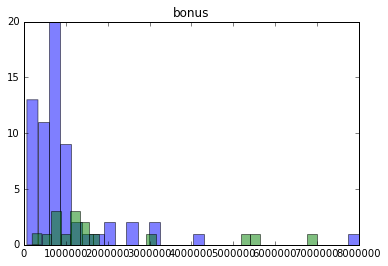

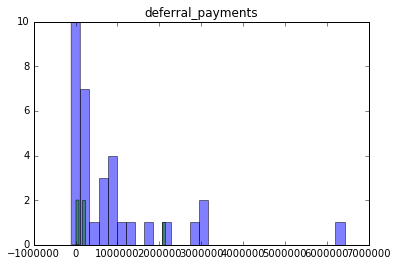

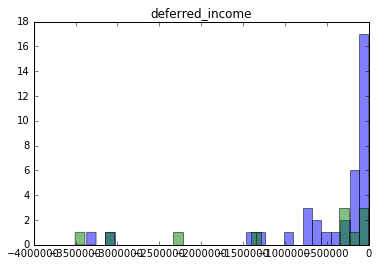

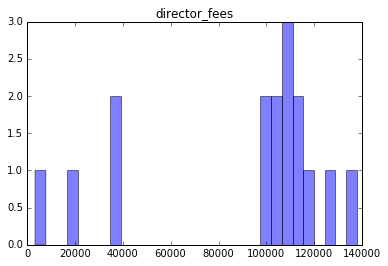

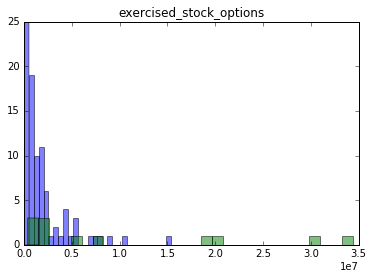

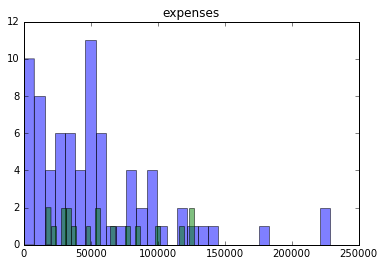

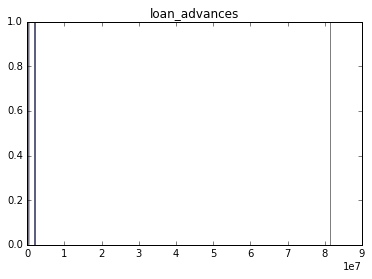

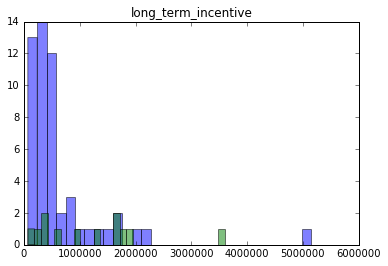

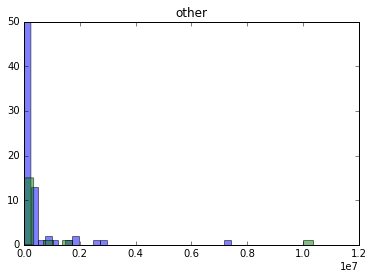

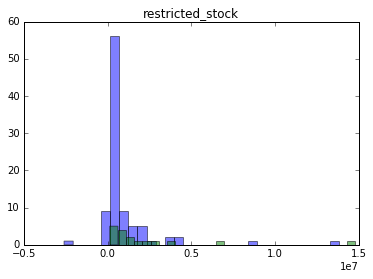

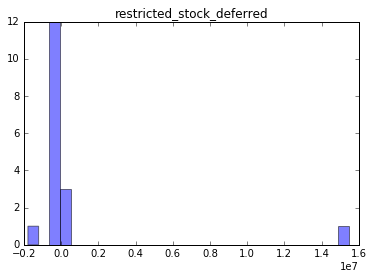

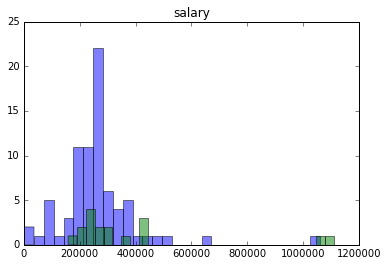

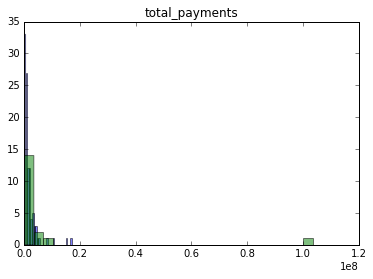

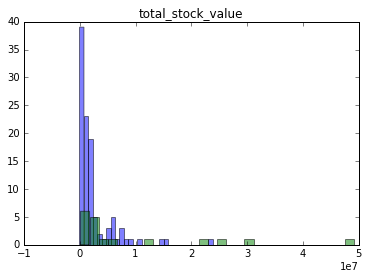

In [24]:
### Look at distribution of each of the financial features
for feature in FINANCIAL_FEATURES:
    plot.hist (df_feat[df_feat["poi"] == False][feature].dropna(), 30, alpha = 0.5, facecolor='blue', \
              label = "Non-POI")
    plot.hist(df_feat[df_feat["poi"] == True][feature].dropna(), 30, alpha = 0.5, \
              facecolor = 'green', label = 'POI')
    plot.title(feature)
    plot.show()

So most of these distribuitons look nothing like a normal curve.  What effect does this have on the machine learning algorithm which expects a normal distribuiton?  Would expect this to confound Naive Bayes, SVM.  Perhaps would not affect decision trees, KNN approach as much.

In [25]:
import math
LOG_FINANCIAL_FEATURES = []
for feature in FINANCIAL_FEATURES:
    df_feat["log_" + feature] = df_feat[feature].apply(lambda x: math.log(x,10) if x > 0 else np.nan)
    LOG_FINANCIAL_FEATURES.append("log_" + feature)


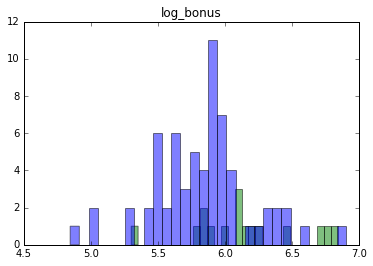

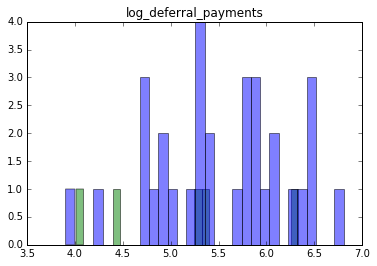

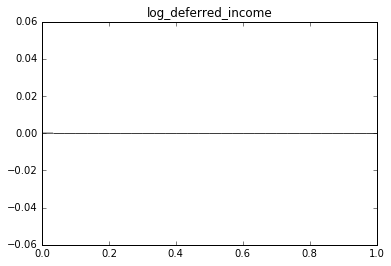

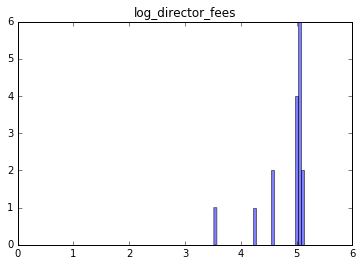

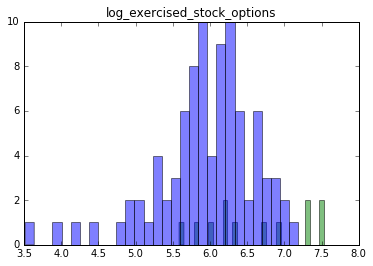

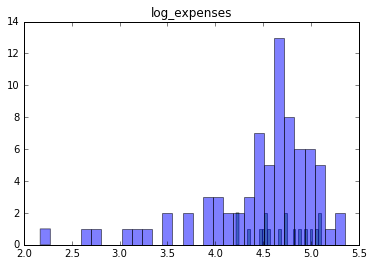

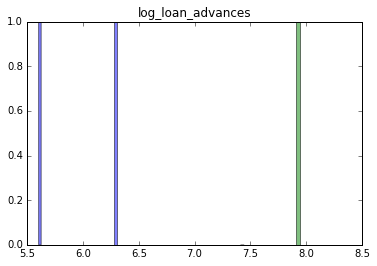

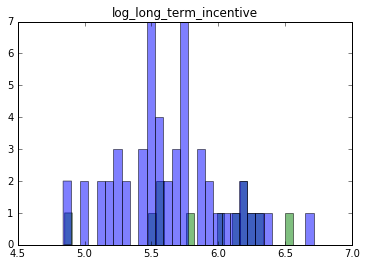

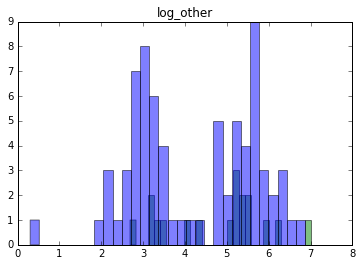

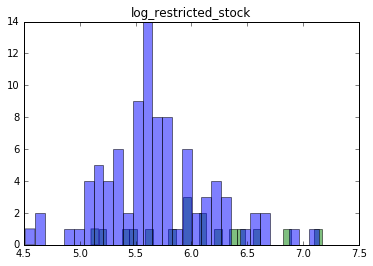

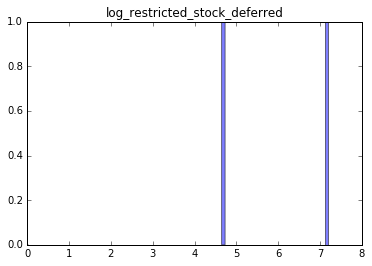

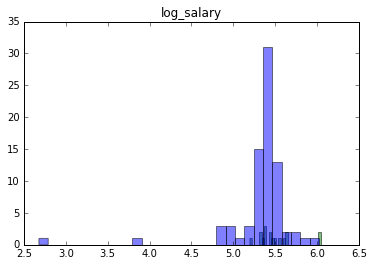

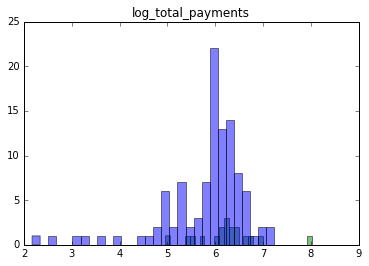

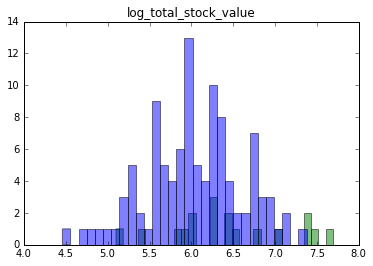

In [26]:
### Look at distribution of log_features
for feature in LOG_FINANCIAL_FEATURES:
    plot.hist(df_feat[df_feat["poi"] == True][feature].dropna(), 30, \
              alpha= 0.5, label = "POI", facecolor = 'green')
    plot.hist(df_feat[df_feat["poi"] == False][feature].dropna(), 30, \
              alpha = 0.5, label = "Non-POI", facecolor = 'blue')
    plot.title(feature)
    plot.show()

The log(feature) distributions, where there is enough data, look much more like normal curve.  Will try log transform of features to see if more effective in ML algorithms.  However there isn't a clear separation visible on looking at the historgrams

In [27]:
### the number of absent data points may itself be a useful feature
df_feat["nulls"] = 21 - df_feat.count(axis = 1)
df_feat[["nulls","poi"]].groupby("poi").median()

,nulls
poi,
False,2.0
True,-4.5


In [28]:
### Does it make sense to drop the 2 entries with a salary < $10,000?  Seems improbable that someone at the
### level of these Enron execs would be making a salary as low as those.
df_feat_sorted = df_feat.sort_values(by = "salary", na_position = "last")
df_feat_sorted.head(5)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,log_expenses,log_loan_advances,log_long_term_incentive,log_other,log_restricted_stock,log_restricted_stock_deferred,log_salary,log_total_payments,log_total_stock_value,nulls
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,4.750516,NaN,NaN,5.936777,6.244908,NaN,2.678518,5.961989,6.719620,-3
GRAY RODNEY,6615.0,NaN,93585.0,1146658.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.563036,5.833041,NaN,NaN,3.820530,6.059434,NaN,8
WESTFAHL RICHARD K,63744.0,NaN,NaN,762135.0,NaN,NaN,384930.0,NaN,NaN,384930.0,...,4.714916,NaN,5.408564,5.603285,5.585382,NaN,4.804439,5.882032,5.585382,3
REYNOLDS LAWRENCE,76399.0,NaN,51365.0,394475.0,4160672.0,100000.0,201483.0,NaN,-140264.0,4221891.0,...,3.924744,NaN,5.193820,5.305463,5.304238,NaN,4.883088,5.596019,6.625507,-4
BAZELIDES PHILIP J,80818.0,NaN,684694.0,860136.0,1599641.0,NaN,NaN,NaN,NaN,1599641.0,...,NaN,NaN,4.971971,2.941511,NaN,NaN,4.907508,5.934567,6.204023,4


In [29]:
# get the names of features in data dictionary
for name, info in data_dict.iteritems():
    feature_names = info.keys()
    break
# initialize a dictionary to hold all the values of each feature
feat_dict = {}
# set each entry to an empty list:
for f_name in feature_names:
    feat_dict[f_name] = []
# iterate through data_dict and add each value to list
for name, info in data_dict.iteritems():
    for k, v in info.iteritems():
        feat_dict[k].append(v)
print feat_dict["salary"][ :10]
### for each numerical feature, count number of nan's
### if a large majority are nan's, perhaps that feature should be excluded from analysis
### if set to zero by feature format, then probably biases it in some way
### not very useful to set most of feature to mean if imputing values

all_numerical_features = FINANCIAL_FEATURES + EMAIL_FEATURES + EMAIL_POI_FEATURES
from collections import defaultdict
null_count = defaultdict(int)
null_count_poi = defaultdict(int)
for name in all_numerical_features:
    for i in range(len(feat_dict[name])):
        if np.isnan(feat_dict[name][i]):
            null_count[name] += 1
            if feat_dict["poi"][i] == True:
                null_count_poi[name] += 1
### print fraction of rows with null sorted by count
TOTAL_ROWS = 144.
N_POI = 18.
N_NPOI = TOTAL_ROWS - N_POI
for name in sorted(null_count, key=null_count.get):
    print " %s : %3.2f, %3.2f" %(name, null_count[name]/TOTAL_ROWS, null_count_poi[name]/N_POI)



[365788, 267102, 170941, nan, 243293, 267093, nan, 370448, nan, 197091]
 total_stock_value : 0.13, 0.00
 total_payments : 0.15, 0.00
 restricted_stock : 0.24, 0.06
 exercised_stock_options : 0.30, 0.33
 salary : 0.35, 0.06
 expenses : 0.35, 0.00
 other : 0.37, 0.00
 to_messages : 0.40, 0.22
 from_poi_to_this_person : 0.40, 0.22
 from_messages : 0.40, 0.22
 from_this_person_to_poi : 0.40, 0.22
 shared_receipt_with_poi : 0.40, 0.22
 bonus : 0.44, 0.11
 long_term_incentive : 0.55, 0.33
 deferred_income : 0.67, 0.39
 deferral_payments : 0.74, 0.72
 restricted_stock_deferred : 0.88, 1.00
 director_fees : 0.89, 1.00
 loan_advances : 0.98, 0.94


In [30]:
no_email = 0
for i in range(len(feat_dict["email_address"])):
    if feat_dict["email_address"][i] == "":
        no_email += 1
print no_email

33


There is an entry "Total" which needs to be removed.  Also remove "THE TRAVEL AGENCY IN THE PARK".
2 values of salary which seem unusually low.  Why?
There are 59 entries with no value for any of the email message counts, but only 33 entries where there is no email address.  So where there is an email address, but no value for email counts, makes sense to impute a mean/median.  Where there is no email address, may mean individual didn't have address at Enron at all and number should be 0?
Some entries with no email address have a salary. 

In [31]:
### Custom imputation function.  Need to apply before the default featureFormat function, which will
### convert all "NaN" to 0

def my_imputer(data, feature_name, strategy = 'median', test = None):
    ### create list of numbers in feature_name, calculate imputed value to use
    feature_vector = []
    for info in data.values():
        if isinstance(info[feature_name], (int,long,float)):
            feature_vector.append(info[feature_name])
    if strategy == 'median':
        imputed_value = np.median(feature_vector)
    for person, info in data.iteritems():
        if info[feature_name] == "NaN":
            if test is not None:
                impute = test(info)
            else:
                impute = True
            if impute:
                data[person][feature_name] = imputed_value

def is_not_director(info):
    ### given a dictionary of feature values "info", returns true if info["director_fees"] is "NaN"
    if info["director_fees"] == "NaN":
        return True
    else:
        return False
    
person_info = {"salary":"NaN", "bonus":500000, "director_fees":"NaN"}
new_dict = {"p1":person_info}
person_info = {"salary": "NaN", "bonus":200000, "director_fees": 500000}
new_dict["p2"] = person_info
person_info = {"salary": 500000, "bonus" : 200000, "director_fees": "NaN"}
new_dict["p3"] = person_info
person_info = {"salary" : 200000, "bonus" : 500000, "director_fees": "NaN"}
new_dict["p4"] = person_info
person_info = {"salary" : 300000, "bonus": 300000, "director_fees": "NaN"}
new_dict["p5"] = person_info

print "before imputation:"
for k in sorted (new_dict.keys()):
    print k, new_dict[k]
my_imputer(new_dict, "salary", strategy = 'median', test = is_not_director)
print "after imputation:"
for k in sorted (new_dict.keys()):
    print k, new_dict[k]



before imputation:
p1 {'salary': 'NaN', 'bonus': 500000, 'director_fees': 'NaN'}
p2 {'salary': 'NaN', 'bonus': 200000, 'director_fees': 500000}
p3 {'salary': 500000, 'bonus': 200000, 'director_fees': 'NaN'}
p4 {'salary': 200000, 'bonus': 500000, 'director_fees': 'NaN'}
p5 {'salary': 300000, 'bonus': 300000, 'director_fees': 'NaN'}
after imputation:
p1 {'salary': 300000.0, 'bonus': 500000, 'director_fees': 'NaN'}
p2 {'salary': 'NaN', 'bonus': 200000, 'director_fees': 500000}
p3 {'salary': 500000, 'bonus': 200000, 'director_fees': 'NaN'}
p4 {'salary': 200000, 'bonus': 500000, 'director_fees': 'NaN'}
p5 {'salary': 300000, 'bonus': 300000, 'director_fees': 'NaN'}


In [32]:
numerator = "from_messages"
for valid_type in [str,list]:
    if type (numerator) is valid_type:
        print "OK"
    else:
        print "Not OK"

OK
Not OK


In [34]:
my_tools.create_ratio_feature(data_dict, "poi_msg_ratio", 
                              ["from_this_person_to_poi", "from_poi_to_this_person"], 
                              ["to_messages", "from_messages"])

In [35]:
i = 0
for k, v in data_dict.iteritems():
    print v["poi_msg_ratio"], v["from_this_person_to_poi"], v["from_poi_to_this_person"], \
    v["from_messages"], v["to_messages"]
    i += 1
    if i > 10: break

0.0466507177033 1 38 29 807
nan nan nan nan nan
nan nan nan nan nan
0.0128865979381 0 10 12 764
0.0492107706592 21 32 32 1045
nan nan nan nan nan
0.0 0 0 28 232
0.0349563046192 26 58 48 2355
0.0172363423897 15 44 1073 2350
0.0746575342466 48 61 222 1238
0.186206896552 17 10 17 128


In [36]:
df_feat.corr()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,log_expenses,log_loan_advances,log_long_term_incentive,log_other,log_restricted_stock,log_restricted_stock_deferred,log_salary,log_total_payments,log_total_stock_value,nulls
salary,1.000000,0.187047,0.455884,0.579260,0.607324,0.523190,0.550824,0.284995,-0.592576,0.614736,...,0.179814,0.749391,0.482846,0.181158,0.497960,NaN,0.654796,0.595132,0.307076,-0.418495
to_messages,0.187047,1.000000,0.310129,0.133834,0.079568,0.372997,0.195570,0.847990,-0.359420,0.120864,...,0.135533,0.897961,0.233316,-0.070569,0.137194,NaN,0.178181,0.263391,0.113138,-0.281042
deferral_payments,0.455884,0.310129,1.000000,0.066774,0.019009,0.293543,0.115088,0.356696,-0.412777,0.075710,...,-0.019690,-1.000000,0.249825,0.213953,0.315690,NaN,0.304151,0.491860,0.284347,-0.339569
total_payments,0.579260,0.133834,0.066774,1.000000,0.591690,0.569054,0.595728,0.191069,0.941613,0.668166,...,0.113639,0.988042,0.373195,0.261419,0.352808,1.0,0.246026,0.371462,0.313396,-0.251431
exercised_stock_options,0.607324,0.079568,0.019009,0.591690,1.000000,0.506998,0.690935,0.154333,-0.051644,0.963560,...,0.113122,1.000000,0.457215,0.226851,0.596342,1.0,0.221087,0.192729,0.694789,-0.170556
bonus,0.523190,0.372997,0.293543,0.569054,0.506998,1.000000,0.376992,0.549102,0.118222,0.509441,...,0.046939,0.998594,0.489546,0.156257,0.317779,NaN,0.479166,0.728609,0.382379,-0.378734
restricted_stock,0.550824,0.195570,0.115088,0.595728,0.690935,0.376992,1.000000,0.232660,-0.867102,0.855250,...,0.087361,1.000000,0.421582,0.364335,0.749238,NaN,0.217017,0.263211,0.608457,-0.152480
shared_receipt_with_poi,0.284995,0.847990,0.356696,0.191069,0.154333,0.549102,0.232660,1.000000,-0.348405,0.176314,...,0.210483,0.546459,0.377538,0.087818,0.221410,NaN,0.232884,0.386853,0.177102,-0.421983
restricted_stock_deferred,-0.592576,-0.359420,-0.412777,0.941613,-0.051644,0.118222,-0.867102,-0.348405,1.000000,-0.819225,...,-0.184592,NaN,-0.294910,0.315343,-0.698289,1.0,-0.073510,0.576106,-0.520563,0.055636
total_stock_value,0.614736,0.120864,0.075710,0.668166,0.963560,0.509441,0.855250,0.176314,-0.819225,1.000000,...,0.110214,0.999983,0.427457,0.279971,0.666670,NaN,0.231539,0.250196,0.706978,-0.207277


In [37]:
### test the create_log_feature function
reload (my_tools)
data = {"1":{"salary":1000, "other":1000}, "2":{"salary":10000, "other":1000},
        "3":{"salary":100000, "other":1000} }
my_tools.create_log_feature(data, "salary")
print data

{'1': {'salary': 1000, 'other': 1000, 'log_salary': 2.9999999999999996}, '3': {'salary': 100000, 'other': 1000, 'log_salary': 5.0}, '2': {'salary': 10000, 'other': 1000, 'log_salary': 4.0}}


In [38]:
len(FINANCIAL_FEATURES)

14